# Capital Bikeshare SQL, Tableau, and Principal Component Analyis Project

## Introduction

Note that the daily rentals table is over 2 GB large.     
Medium article: https://medium.com/@erkansirin/worst-way-to-write-pandas-dataframe-to-database-445ec62025e0     
DuckDB: https://duckdb.org/docs/api/python/overview   
SQLite Setup: https://www.kaggle.com/code/jacopoferretti/san-francisco-fire-dept-calls-data-an-w-sqlite   


## Project Code

### Import the database and required libraries/packages

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
daily_rentals_columns = ['ride_id', 'started_at', 'ended_at', 'start_station_id', 'end_station_id', 'member_casual']

daily_rentals = pd.read_csv('daily_rent_detail.csv', usecols=daily_rentals_columns)
station_list = pd.read_csv('station_list.csv')
weather = pd.read_csv('weather.csv')

D:\Programs\Anaconda\Dwiggins\AppData\Local\Temp\ipykernel_21856\431486821.py:3: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  daily_rentals = pd.read_csv('daily_rent_detail.csv', usecols=daily_rentals_columns)


Understand the data types of each column, and convert as necessary

In [3]:
daily_rentals.dtypes

ride_id             object
started_at          object
ended_at            object
start_station_id    object
end_station_id      object
member_casual       object
dtype: object

In [4]:
daily_rentals['ride_id'] = daily_rentals['ride_id'].astype('string')
daily_rentals['started_at'] = pd.to_datetime(daily_rentals['started_at'], format = 'ISO8601')
daily_rentals['ended_at'] = pd.to_datetime(daily_rentals['ended_at'], format = 'ISO8601')
daily_rentals['start_station_id'] = daily_rentals['start_station_id'].astype('string')
daily_rentals['end_station_id'] = daily_rentals['end_station_id'].astype('string')
daily_rentals['member_casual'] = daily_rentals['member_casual'].astype('string')

daily_rentals.dtypes

ride_id             string[python]
started_at          datetime64[ns]
ended_at            datetime64[ns]
start_station_id    string[python]
end_station_id      string[python]
member_casual       string[python]
dtype: object

In [5]:
station_list['station_name'] = station_list['station_name'].astype('string')

station_list.dtypes

station_id               int64
station_name    string[python]
dtype: object

In [6]:
weather.dtypes

name                 object
datetime             object
tempmax             float64
tempmin             float64
temp                float64
feelslikemax        float64
feelslikemin        float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob            int64
precipcover         float64
preciptype           object
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
solarenergy         float64
uvindex               int64
severerisk          float64
sunrise              object
sunset               object
moonphase           float64
conditions           object
description          object
icon                 object
stations             object
dtype: object

In [7]:
weather['name'] = weather['name'].astype('string')
weather['datetime'] = pd.to_datetime(weather['datetime'], format = 'ISO8601')
weather['sunrise'] = pd.to_datetime(weather['sunrise'], format = 'ISO8601')
weather['sunset'] = pd.to_datetime(weather['sunset'], format = 'ISO8601')
weather['conditions'] = weather['conditions'].astype('string')
weather['description'] = weather['description'].astype('string')
weather['icon'] = weather['icon'].astype('string')
weather['stations'] = weather['stations'].astype('string')

weather.dtypes

name                string[python]
datetime            datetime64[ns]
tempmax                    float64
tempmin                    float64
temp                       float64
feelslikemax               float64
feelslikemin               float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                   int64
precipcover                float64
preciptype                  object
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                      int64
severerisk                 float64
sunrise             datetime64[ns]
sunset              datetime64[ns]
moonphase           

### Analysis

Big questions to ask:   
1. What do renting patterns look like now?
2. How do renting patterns change with the weather or time of year?
3. Could you predict the demand from the weather?

**1. What do renting patterns look like now?**

How have renting patterns changed over a year-long cycle? Is there some cyclical nature to it?

In [8]:
# How many months and years does this dataset span
duckdb.sql("""
    SELECT EXTRACT(MONTH FROM started_at) AS month, EXTRACT(YEAR FROM started_at) AS year, COUNT(ride_id) AS rides_taken
    FROM daily_rentals
    GROUP BY EXTRACT(YEAR FROM started_at), EXTRACT(MONTH FROM started_at)
    ORDER BY year, month;
""").fetchdf()

,month,year,rides_taken
0,5,2020,149051
1,6,2020,214047
2,7,2020,228347
3,8,2020,251603
4,9,2020,249899
5,10,2020,229832
6,11,2020,175435
7,12,2020,105829
8,1,2021,100070
9,2,2021,77505


In [9]:
# Visualize the growth of the bikeshare by casual riders and members over time
rides_growth = duckdb.sql("""
    SELECT 
        EXTRACT(MONTH FROM started_at) AS month, 
        EXTRACT(YEAR FROM started_at) AS year,
        COUNT(CASE WHEN member_casual = 'member' THEN ride_id END) AS member_rides,
        COUNT(CASE WHEN member_casual = 'casual' THEN ride_id END) AS casual_rides
    FROM 
        daily_rentals
    GROUP BY 
        EXTRACT(YEAR FROM started_at), 
        EXTRACT(MONTH FROM started_at)
    ORDER BY 
        year, month;
""").fetchdf()

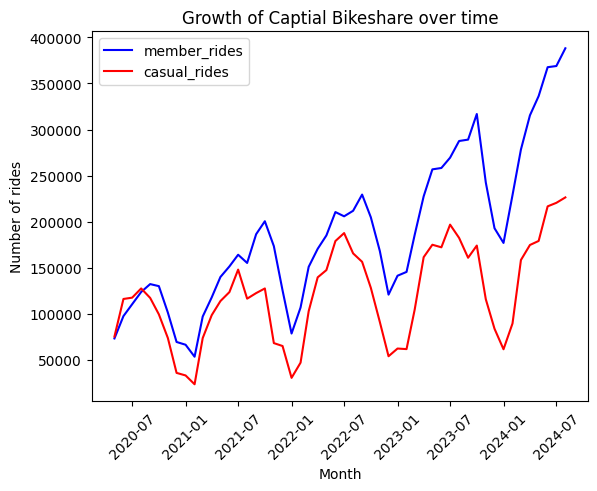

In [10]:
# Combine rows and select data
rides_growth['month_year'] = rides_growth['month'].astype(str) + '-' + rides_growth['year'].astype(str)
rides_growth['month_year'] = pd.to_datetime(rides_growth['month_year'], format = '%m-%Y')
x = rides_growth['month_year']
y1 = rides_growth['member_rides']
y2 = rides_growth['casual_rides']

# Make plots
fig, ax = plt.subplots()
plt.plot(x, y1, color = 'b', label = 'member_rides')
plt.plot(x, y2, color = 'r', label = 'casual_rides')
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Number of rides')
plt.title('Growth of Captial Bikeshare over time')
plt.legend()
plt.show()

There is a cyclical nature of rides throughout the year. Bike rides seem to peak during late summer and seem to dip to a mimimum at the beginning of each year. Let's zoom into the details of one year specifically (from January 2023 to December 2023)

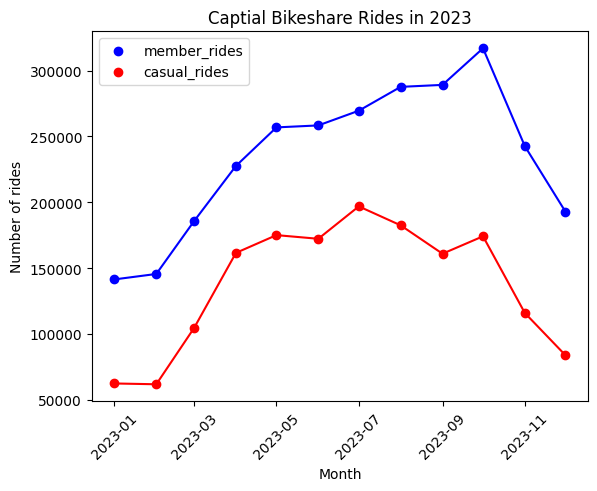

In [11]:
# Select data
x = rides_growth[(rides_growth.month_year >= pd.to_datetime('2023-01-01')) & (rides_growth.month_year < pd.to_datetime('2024-01-01'))]['month_year']
y1 = rides_growth[(rides_growth.month_year >= pd.to_datetime('2023-01-01')) & (rides_growth.month_year < pd.to_datetime('2024-01-01'))]['member_rides']
y2 = rides_growth[(rides_growth.month_year >= pd.to_datetime('2023-01-01')) & (rides_growth.month_year < pd.to_datetime('2024-01-01'))]['casual_rides']

# Create plot
fig, ax = plt.subplots()
plt.scatter(x, y1, color = 'b', label = 'member_rides')
plt.plot(x, y1, color = 'b')
plt.scatter(x, y2, color = 'r', label = 'casual_rides')
plt.plot(x, y2, color = 'r')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Number of rides')
plt.title('Captial Bikeshare Rides in 2023')
plt.xticks(rotation = 45)
plt.show()

The graph shows that bikeshare rides peaked in October 2023 for members and in July 2023 for non-members. Is there a pattern of behavior between member rides and casual rides for the peak month? Let's find out.

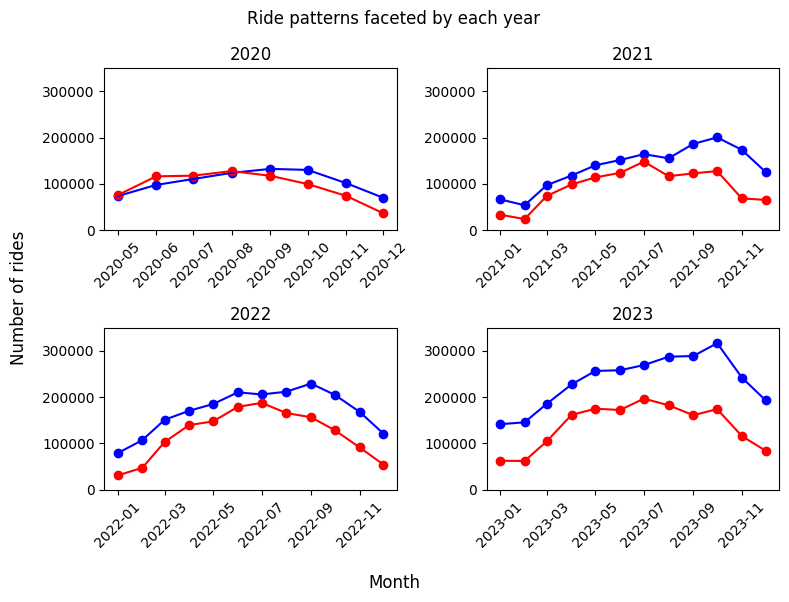

In [12]:
def select_data_year(dataframe, start_date, end_date):
    x = rides_growth[(rides_growth.month_year >= pd.to_datetime(start_date)) & (rides_growth.month_year < pd.to_datetime(end_date))]['month_year']
    y1 = rides_growth[(rides_growth.month_year >= pd.to_datetime(start_date)) & (rides_growth.month_year < pd.to_datetime(end_date))]['member_rides']
    y2 = rides_growth[(rides_growth.month_year >= pd.to_datetime(start_date)) & (rides_growth.month_year < pd.to_datetime(end_date))]['casual_rides']
    return x, y1, y2

date_ranges = [
    ('2020-01-01', '2021-01-01'),
    ('2021-01-01', '2022-01-01'),
    ('2022-01-01', '2023-01-01'),
    ('2023-01-01', '2024-01-01')
]

fig, axs = plt.subplots(2, 2, figsize = (8, 6))

for date_range in date_ranges:
    plt.subplot(2, 2, date_ranges.index(date_range) + 1)
    x, y1, y2 = select_data_year(rides_growth, date_range[0], date_range[1])
    plt.scatter(x, y1, color = 'b', label = 'member_rides')
    plt.plot(x, y1, color = 'b')
    plt.scatter(x, y2, color = 'r', label = 'casual_rides')
    plt.plot(x, y2, color = 'r')
    ax = plt.gca()
    ax.set_ylim([0, 350000])
    ax.set_title(date_range[0][0:4])
    plt.xticks(rotation = 45)
    
fig.supxlabel('Month')
fig.supylabel('Number of rides')
fig.suptitle('Ride patterns faceted by each year')
fig.tight_layout()
plt.show()

The graph here shows an overall trend that member rides tend to peak in October and casual rides tend to peak around July. Bike rides also are lowest during January and February months.

These graphs give good information about how renting patterns change with the time of the year, as well as what renting patterns look like now.

**2. How do renting patterns change with weather?**

We care about:
- What day the ride started
- The ride duration
- How many rides (unlocks) occurred each day
- The total ride time each day
- How weather impacts these metrics

Why: Captial Bikeshare charges 1.00 to unlock and 0.05 per minute for a classic bike and 0.15 per minute for an ebike.

This will translate to how profits could be connected to the weather

In [13]:
daily_rides_agg = pd.read_csv('daily_rides_agg.csv')
daily_rides_agg.head()

,index,date,total_rides,total_duration_mins
0,0,2020-05-01,2969,91076.58
1,1,2020-05-02,9028,897015.15
2,2,2020-05-03,3663,190313.00
3,3,2020-05-04,3718,230021.55
4,4,2020-05-05,2374,90237.02


In [14]:
rides_weather = duckdb.sql("""
    SELECT
        r.date,
        r.total_rides,
        r.total_duration_mins,
        w.temp,
        w.feelslike,
        w.dew,
        w.humidity,
        w.precip,
        w.precipprob,
        w.precipcover,
        w.preciptype,
        w.snow,
        w.snowdepth,
        w.windgust,
        w.windspeed,
        w.sunrise,
        w.sunset
    FROM daily_rides_agg AS r
    LEFT JOIN weather AS w
    ON r.date = w.datetime::date
""").fetchdf()

In [15]:
rides_weather.head(5)

,date,total_rides,total_duration_mins,temp,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,sunrise,sunset
0,2020-05-02,9028,897015.15,16.3,16.3,6.4,54.0,0.000,0,0.00,None,0.0,0.0,39.6,26.1,2020-05-02 06:08:30,2020-05-02 20:02:13
1,2020-05-03,3663,190313.00,18.6,18.6,13.4,72.5,10.234,100,16.67,rain,0.0,0.0,46.8,21.4,2020-05-03 06:07:21,2020-05-03 20:03:11
2,2020-05-04,3718,230021.55,19.2,19.2,7.8,53.8,15.555,100,12.50,rain,0.0,0.0,68.8,44.9,2020-05-04 06:06:12,2020-05-04 20:04:08
3,2020-05-05,2374,90237.02,12.3,12.1,3.3,55.6,4.488,100,16.67,rain,0.0,0.0,28.4,24.0,2020-05-05 06:05:06,2020-05-05 20:05:05
4,2020-05-06,1385,53953.22,11.2,10.5,7.8,80.9,1.657,100,33.33,rain,0.0,0.0,42.7,27.0,2020-05-06 06:04:00,2020-05-06 20:06:02


In [16]:
rides_weather[['total_rides', 'total_duration_mins']].describe()

,total_rides,total_duration_mins
count,1581.000000,1.581000e+03
mean,10160.891841,2.455812e+05
std,4808.462515,1.575544e+05
min,497.000000,1.300537e+04
25%,6648.000000,1.377642e+05
50%,9697.000000,2.312345e+05
75%,13512.000000,3.203330e+05
max,24193.000000,2.008579e+06


There are some values that do not make sense. Let's clean those out.

In [17]:
rides_weather[rides_weather.total_duration_mins < 0]

,date,total_rides,total_duration_mins,temp,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,sunrise,sunset


What happened? There are three dates where the total duration in minutes is a very large negative number.

In [18]:
daily_rentals[(daily_rentals['started_at'].dt.normalize() == np.datetime64('2024-02-18')) & (daily_rentals['started_at'] > daily_rentals['ended_at'])]

,ride_id,started_at,ended_at,start_station_id,end_station_id,member_casual
12568990,663F9863ABF1EB13,2024-02-18 13:41:37,2000-01-01 15:55:56,31522.0,<NA>,member
12616845,AA2A0543063BF2EA,2024-02-18 18:21:24,2024-02-18 18:20:24,31201.0,<NA>,member
12808158,CEA8CBD1E5C764F2,2024-02-18 12:27:58,2024-02-18 12:27:34,31257.0,<NA>,casual


Lets drop the rows that have negative values for the durations.

In [19]:
rides_weather = rides_weather.drop(rides_weather[rides_weather['total_duration_mins'] < 0].index, axis = 0)
rides_weather = rides_weather.reset_index()

What about missing values?

In [20]:
rides_weather.isna().sum()

index                    0
date                     0
total_rides              0
total_duration_mins      0
temp                     0
feelslike                0
dew                      0
humidity                 0
precip                   0
precipprob               0
precipcover              0
preciptype             824
snow                     0
snowdepth                0
windgust                 0
windspeed                0
sunrise                  0
sunset                   0
dtype: int64

No missing values in our dataframe of interest.

Let's draw a few scatter plots on the total rides taken and the total ride duration for the day and see how they relate to temperature and other weather metric.

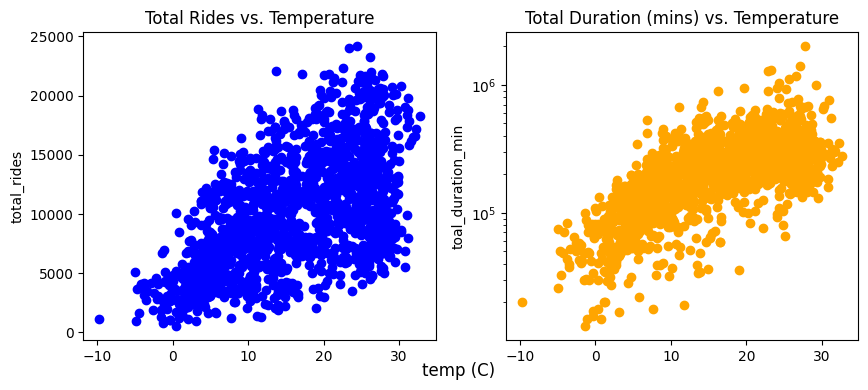

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
x = rides_weather['temp']
y = rides_weather['total_rides']

plt.subplot(1, 2, 1)
plt.scatter(x, y, color = 'b')
ax = plt.gca()
ax.set_title('Total Rides vs. Temperature')
ax.set_ylabel('total_rides')

plt.subplot(1, 2, 2)
y = rides_weather['total_duration_mins']
plt.scatter(x, y, color = 'orange')
plt.yscale(value = 'log', nonpositive = 'clip')
ax = plt.gca()
ax.set_title('Total Duration (mins) vs. Temperature')
ax.set_ylabel('toal_duration_min')

fig.supxlabel('temp (C)')
plt.show()

These two graphs show some correlation between the total rides and the temperature, as well as the total ride duration and the temperature. There seems to be a stronger correlation between the total ride duration and the temperature.

In [22]:
rides_weather['preciptype']

0       None
1       rain
2       rain
3       rain
4       rain
        ... 
1576    None
1577    rain
1578    rain
1579    None
1580    rain
Name: preciptype, Length: 1581, dtype: object

In [23]:
rides_weather['preciptype'] = rides_weather['preciptype'].apply(lambda x: x if x != None else 'clear')
rides_weather['preciptype']

0       clear
1        rain
2        rain
3        rain
4        rain
        ...  
1576    clear
1577     rain
1578     rain
1579    clear
1580     rain
Name: preciptype, Length: 1581, dtype: object

In [24]:
rides_by_precip = duckdb.sql("""
    SELECT 
        preciptype,
        AVG(total_rides) AS avg_rides_for_precip,
        STDDEV(total_rides) AS std_rides_for_precip,
        COUNT(total_rides) AS count_rides_for_precip
    FROM rides_weather
    GROUP BY preciptype
    HAVING COUNT(total_rides) >= 10
""").fetchdf()

rides_by_precip

,preciptype,avg_rides_for_precip,std_rides_for_precip,count_rides_for_precip
0,snow,4212.833333,1444.545404,12
1,clear,10704.046117,4752.959472,824
2,"rain,snow",3250.666667,2174.113011,39
3,freezingrain,9043.800000,2536.683828,10
4,rain,10085.665211,4647.012763,687


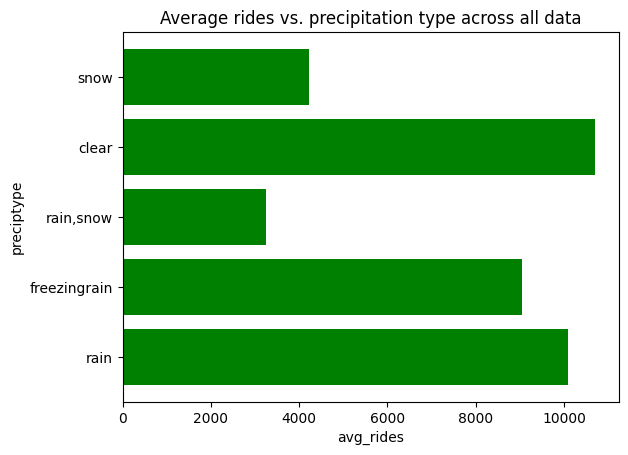

In [25]:
fig, ax = plt.subplots()
x = rides_by_precip['preciptype']
y = rides_by_precip['avg_rides_for_precip']

plt.barh(x, y, color = 'green')
ax.invert_yaxis()
# plt.xscale(value = 'log')
plt.xlabel('avg_rides')
plt.ylabel('preciptype')
plt.title('Average rides vs. precipitation type across all data')
plt.show()

Precipitation type affects the activity, but only when snow is involved it seems.

In [26]:
rides_weather['precipcover'].unique()

array([ 0.  , 16.67, 12.5 , 33.33,  8.33,  4.17, 45.83, 20.83, 37.5 ,
       25.  , 50.  , 62.5 , 29.17, 58.33, 41.67, 91.67, 66.67, 54.17,
       75.  , 70.83, 87.5 , 83.33, 95.83, 79.17])

In [27]:
rides_weather['precipprob']

0         0
1       100
2       100
3       100
4       100
       ... 
1576      0
1577    100
1578    100
1579      0
1580    100
Name: precipprob, Length: 1581, dtype: int64

In [50]:
rides_weather['precipprob'].unique()

array([  0, 100], dtype=int64)

In [28]:
rides_by_precipcover = duckdb.sql("""
    SELECT 
        precipcover, 
        AVG(total_rides) AS avg_total_rides,
        STDDEV(total_rides) AS std_total_rides,
        COUNT(total_rides) AS count_total_rides
    FROM rides_weather
    GROUP BY precipcover
    ORDER BY precipcover
""").fetchdf()

rides_by_precipcover

,precipcover,avg_total_rides,std_total_rides,count_total_rides
0,0.00,10838.462185,4766.664220,952
1,4.17,10856.594595,4515.760653,111
2,8.33,11546.086957,4689.809937,92
3,12.50,11216.223881,4366.435953,67
4,16.67,9765.322034,4681.965519,59
5,20.83,9660.224138,4268.286266,58
6,25.00,8946.977273,3312.127557,44
7,29.17,6172.166667,3544.651192,30
8,33.33,6905.000000,3789.385199,33
9,37.50,6491.080000,3640.745436,25


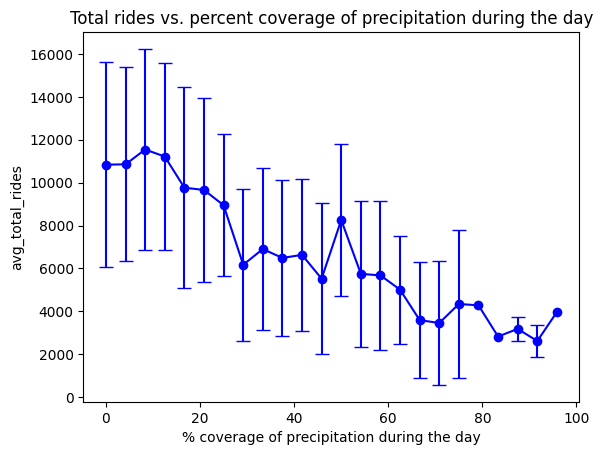

In [29]:
fig, ax = plt.subplots()

x = rides_by_precipcover['precipcover']
y = rides_by_precipcover['avg_total_rides']
error = rides_by_precipcover['std_total_rides']

plt.errorbar(x, y, yerr = error, color = 'blue', capsize = 5, capthick = 1)
plt.scatter(x, y, color = 'blue')
plt.xlabel('% coverage of precipitation during the day')
plt.ylabel('avg_total_rides')
plt.title('Total rides vs. percent coverage of precipitation during the day')
plt.show()

This shows that there is some downward trend in the average total rides as the % coverage of precipitation increases during for the day. The error bars demonstrate overlap between groups but it is possible there is some signal, a statistical test would need to be employed to know for sure. Error bars represent the standard deviation.

One thing that would be interesting is how do total rides and total minutes vary with how much daylight is available during the day?

In [30]:
rides_weather['daylight'] = rides_weather['sunset'] - rides_weather['sunrise']
rides_weather['daylight'] = rides_weather['daylight'].apply(lambda x: x / np.timedelta64(1, 'h'))
rides_weather['daylight']

0       13.895278
1       13.930556
2       13.965556
3       13.999722
4       14.033889
          ...    
1576    12.953333
1577    12.041111
1578    10.259722
1579    14.866667
1580    13.243611
Name: daylight, Length: 1581, dtype: float64

In [31]:
rides_weather['date'] = pd.to_datetime(rides_weather['date'])

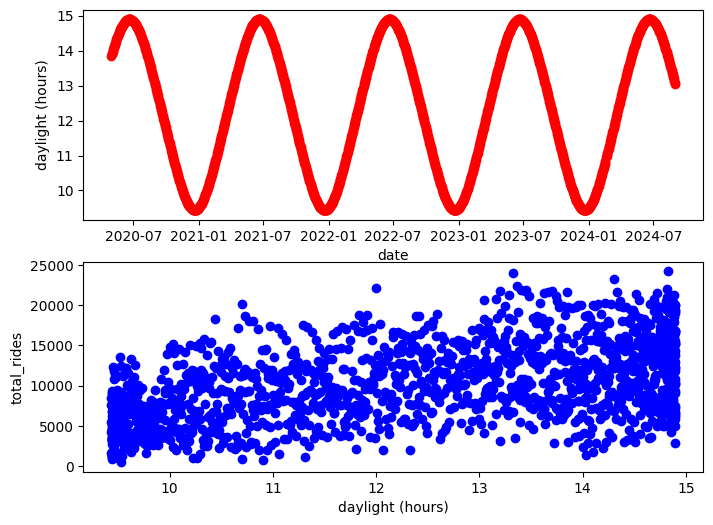

In [32]:
fig, ax = plt.subplots(2,1, figsize = (8, 6))

x = rides_weather['date']
y = rides_weather['daylight']
plt.subplot(2,1,1)
plt.scatter(x, y, color = 'red')
# plt.scatter(x, y, color = 'red')
plt.ylabel('daylight (hours)')
plt.xlabel('date')

plt.subplot(2,1,2)
x = rides_weather['daylight']
y = rides_weather['total_rides']
plt.scatter(x, y, color = 'blue')
plt.ylabel('total_rides')
plt.xlabel('daylight (hours)')

plt.show()

This shows that there is some possible correlation with the total rides and the number of hours of daylight in the day.

How are the total_rides and the total_duration_mins impacted by the amount of precipitation (rain and snow)?

In [33]:
rides_weather[['precip', 'snow', 'snowdepth']].describe()

,precip,snow,snowdepth
count,1581.000000,1581.000000,1581.000000
mean,2.940367,0.050411,0.074826
std,7.858171,0.509040,0.528000
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.125000,0.000000,0.000000
max,68.131000,9.300000,8.200000


In [34]:
def classifyPrecip(x):
    if x == 0:
        return "0"
    elif (x > 0) and (x <= 10):
        return "0 < x <= 10"
    elif (x > 10) and (x <= 20):
        return "10 < x <= 20"
    elif (x > 20) and (x <= 30):
        return "20 < x <= 30"
    else:
        return "> 30"

def classifySnow(x):
    if x == 0:
        return "0"
    else:
        return "> 0"

def classifySnowdepth(x):
    if x == 0:
        return "0"
    elif (x > 0) and (x <= 0.5):
        return "0 < x <= 0.5"
    else:
        return "> 0.5"
    
rides_weather['precipLevel'] = rides_weather['precip'].map(classifyPrecip)
rides_weather['snowLevel'] = rides_weather['snow'].map(classifySnow)
rides_weather['snowDepthLevel'] = rides_weather['snowdepth'].map(classifySnowdepth)

In [35]:
rides_weather[['precipLevel', 'snowLevel', 'snowDepthLevel']].head(5)

,precipLevel,snowLevel,snowDepthLevel
0,0,0,0
1,10 < x <= 20,0,0
2,10 < x <= 20,0,0
3,0 < x <= 10,0,0
4,0 < x <= 10,0,0


In [36]:
sum_precipLevel = duckdb.sql("""
    SELECT 
        precipLevel, 
        AVG(total_rides) AS avg_total_rides,
        STDDEV(total_rides) AS std_total_rides,
        COUNT(total_rides) AS count_total_rides
    FROM rides_weather
    GROUP BY precipLevel
    ORDER BY precipLevel;
""").fetchdf()

sum_precipLevel

,precipLevel,avg_total_rides,std_total_rides,count_total_rides
0,0,10838.462185,4766.664220,952
1,0 < x <= 10,9877.322581,4611.107393,465
2,10 < x <= 20,7813.278351,4359.881776,97
3,20 < x <= 30,5489.485714,4317.989642,35
4,> 30,6349.343750,3415.981006,32


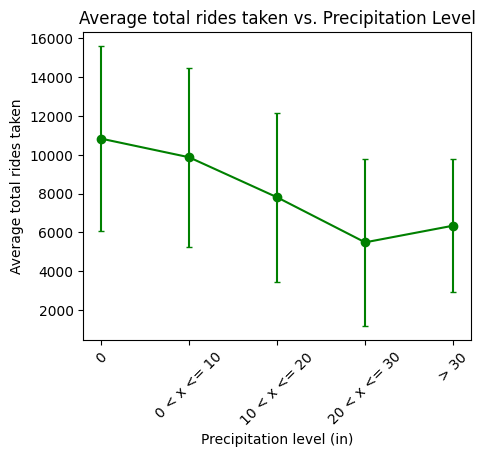

In [37]:
fig, ax = plt.subplots(figsize = (5, 4))

x = sum_precipLevel['precipLevel']
y = sum_precipLevel['avg_total_rides']
error = sum_precipLevel['std_total_rides']

plt.errorbar(x, y, yerr = error, color = 'green', capsize = 2, capthick = 1)
plt.scatter(x, y, color = 'green')
plt.xlabel('Precipitation level (in)')
plt.xticks(rotation=45)
plt.ylabel('Average total rides taken')
plt.title('Average total rides taken vs. Precipitation Level')
plt.show()

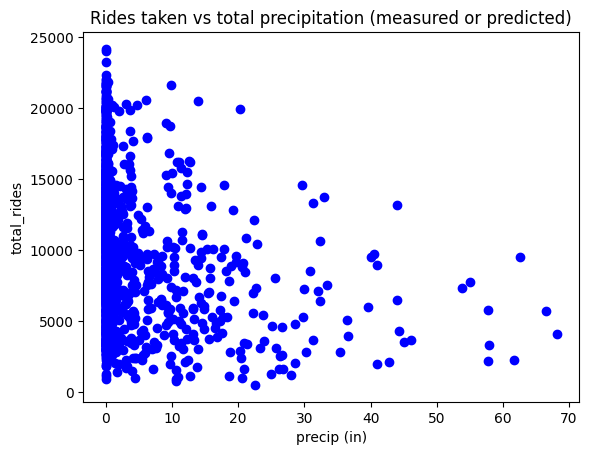

In [38]:
fig, ax = plt.subplots()

x = rides_weather['precip']
y = rides_weather['total_rides']

plt.scatter(x, y, color = 'blue')
plt.xlabel('precip (in)')
plt.ylabel('total_rides')
plt.title('Rides taken vs total precipitation (measured or predicted)')
plt.show()

Both graphs show that there is not a big difference between the level of precipitation

In [39]:
sum_snowLevel = duckdb.sql("""
    SELECT 
        snowLevel, 
        AVG(total_rides) AS avg_total_rides,
        STDDEV(total_rides) AS std_total_rides,
        COUNT(total_rides) AS count_total_rides
    FROM rides_weather
    GROUP BY snowLevel
    ORDER BY snowLevel;
""").fetchdf()

sum_snowLevel

,snowLevel,avg_total_rides,std_total_rides,count_total_rides
0,0,10334.578095,4726.350675,1543
1,> 0,3108.315789,2008.435402,38


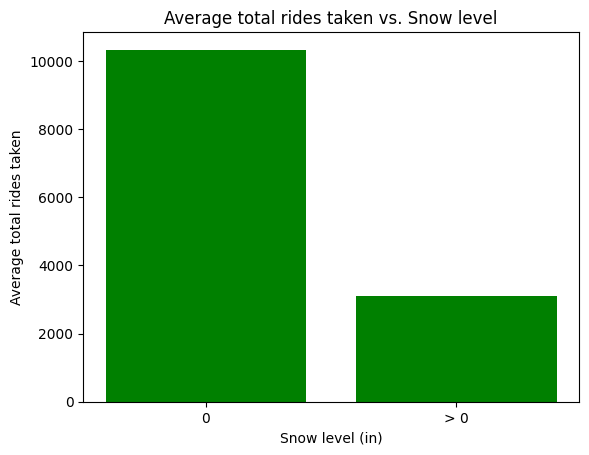

In [40]:
fig, ax = plt.subplots()

x = sum_snowLevel['snowLevel']
y = sum_snowLevel['avg_total_rides']

plt.bar(x, y, color = 'green')
plt.xlabel('Snow level (in)')
plt.ylabel('Average total rides taken')
plt.title('Average total rides taken vs. Snow level')
plt.show()

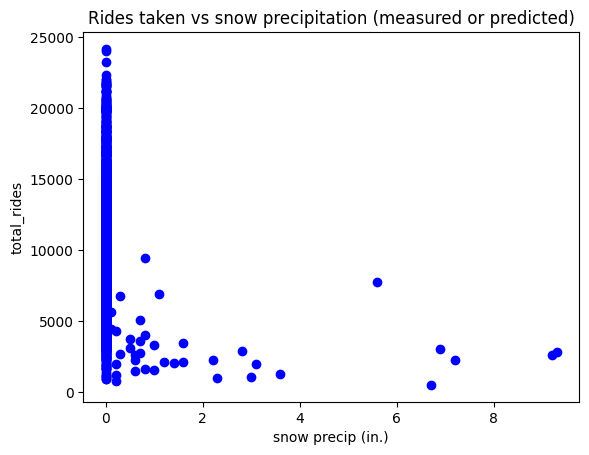

In [41]:
fig, ax = plt.subplots()

x = rides_weather['snow']
y = rides_weather['total_rides']

plt.scatter(x, y, color = 'blue')
plt.xlabel('snow precip (in.)')
plt.ylabel('total_rides')
plt.title('Rides taken vs snow precipitation (measured or predicted)')
plt.show()

This scatterplot shows that there is not a correlation, due to all of the observations with 0 in. snow precipitation, but that there is a significantly lower number of average total rides taken in the nonzero category compare to the zero category. Thus, the categorization would be stronger for a machine learning model.

In [42]:
sum_snowAccLevel = duckdb.sql("""
    SELECT 
        snowDepthLevel, 
        AVG(total_rides) AS avg_total_rides,
        STDDEV(total_rides) AS std_total_rides,
        COUNT(total_rides) AS count_total_rides
    FROM rides_weather
    GROUP BY snowDepthLevel
    ORDER BY snowDepthLevel;
""").fetchdf()

sum_snowAccLevel

,snowDepthLevel,avg_total_rides,std_total_rides,count_total_rides
0,0,10513.373582,4661.429817,1499
1,0 < x <= 0.5,3954.622222,1910.748940,45
2,> 0.5,3428.783784,2498.154098,37


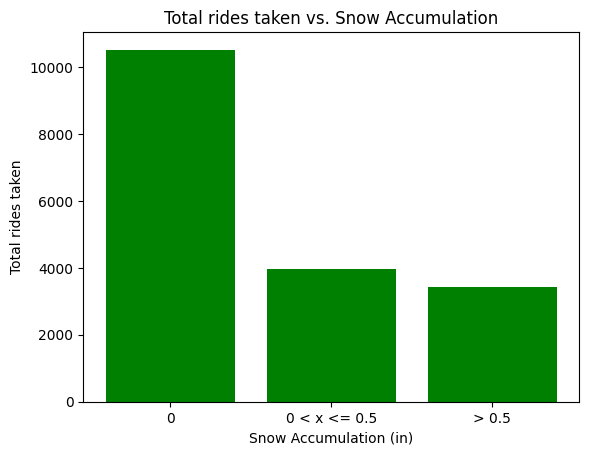

In [43]:
fig, ax = plt.subplots()

x = sum_snowAccLevel['snowDepthLevel']
y = sum_snowAccLevel['avg_total_rides']

plt.bar(x, y, color = 'green')
plt.xlabel('Snow Accumulation (in)')
plt.ylabel('Total rides taken')
plt.title('Total rides taken vs. Snow Accumulation')
plt.show()

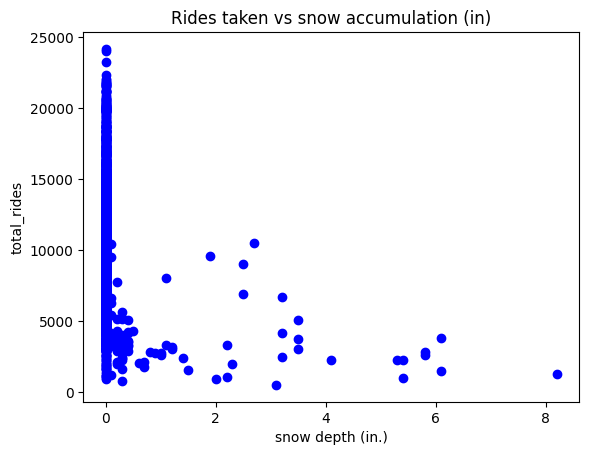

In [44]:
fig, ax = plt.subplots()

x = rides_weather['snowdepth']
y = rides_weather['total_rides']

plt.scatter(x, y, color = 'blue')
plt.xlabel('snow depth (in.)')
plt.ylabel('total_rides')
plt.title('Rides taken vs snow accumulation (in)')
plt.show()

Again there is a clear drop off in average total rides with any nonzero level of snowfall. From a mathematical standpoint there is no correlation here (due to all of the observations at 0 in. snow depth) but when grouped into categories there is a clear indication as to which category gets more rides.

Wind speed

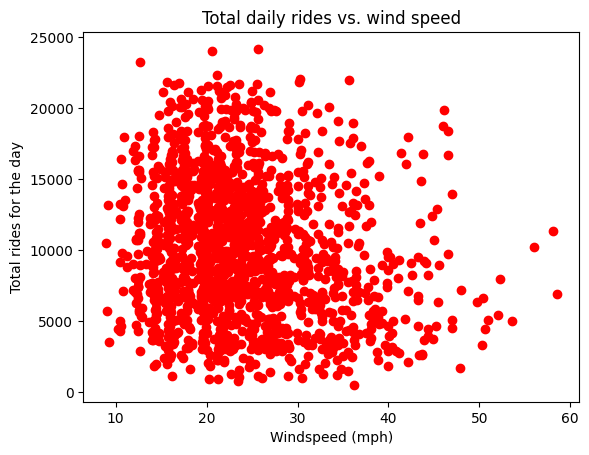

In [45]:
fig, ax = plt.subplots()

x = rides_weather['windspeed']
y = rides_weather['total_rides']

plt.scatter(x, y, color = 'red')
plt.xlabel('Windspeed (mph)')
plt.ylabel('Total rides for the day')
plt.title('Total daily rides vs. wind speed')
plt.show()

No correlation at all between wind speed and total rides for the day.

What about rides and humidity or dew point?

In [46]:
rides_weather[['humidity', 'dew']].describe()

,humidity,dew
count,1581.000000,1581.000000
mean,63.792853,8.737381
std,13.574314,9.711513
min,24.300000,-19.200000
25%,54.300000,0.600000
50%,64.000000,9.600000
75%,73.700000,17.400000
max,96.900000,24.200000


In [47]:
rides_humidity = duckdb.sql("""
    SELECT 
        CASE
            WHEN humidity > 20 AND humidity <= 30 THEN '20-30'
            WHEN humidity > 30 AND humidity <= 40 THEN '30-40'
            WHEN humidity > 40 AND humidity <= 50 THEN '40-50'
            WHEN humidity > 50 AND humidity <= 60 THEN '50-60'
            WHEN humidity > 60 AND humidity <= 70 THEN '60-70'
            WHEN humidity > 70 AND humidity <= 80 THEN '70-80'
            WHEN humidity > 80 AND humidity <= 90 THEN '80-90'
            WHEN humidity > 90 AND humidity <= 100 THEN '90-100'
            ELSE 'other'
        END AS humidity_category,
        AVG(total_rides) AS avg_total_rides, 
        AVG(total_duration_mins) AS avg_total_duration_mins,
        STDDEV(total_rides) AS std_total_rides,
        STDDEV(total_duration_mins) AS std_duration_mins,
        COUNT(total_rides) AS observ_total_rides,
        COUNT(total_duration_mins) AS observ_total_duration_mins
    FROM rides_weather
    GROUP BY humidity_category
    ORDER BY humidity_category
""").fetchdf()

rides_humidity

,humidity_category,avg_total_rides,avg_total_duration_mins,std_total_rides,std_duration_mins,observ_total_rides,observ_total_duration_mins
0,20-30,7342.250000,257208.217500,2881.265853,101231.905443,4,4
1,30-40,9274.633333,222372.406333,4178.313884,138423.463516,60,60
2,40-50,9839.823232,234466.014293,5194.938438,157278.983069,198,198
3,50-60,10964.123037,259382.869712,4868.412361,159981.876857,382,382
4,60-70,11326.901299,272275.136286,4602.105057,165759.585149,385,385
5,70-80,9818.486034,248344.757291,4599.883862,151052.033132,358,358
6,80-90,7909.987578,192414.029441,4117.409024,138294.726376,161,161
7,90-100,5835.151515,111277.592727,3475.167830,83137.839669,33,33


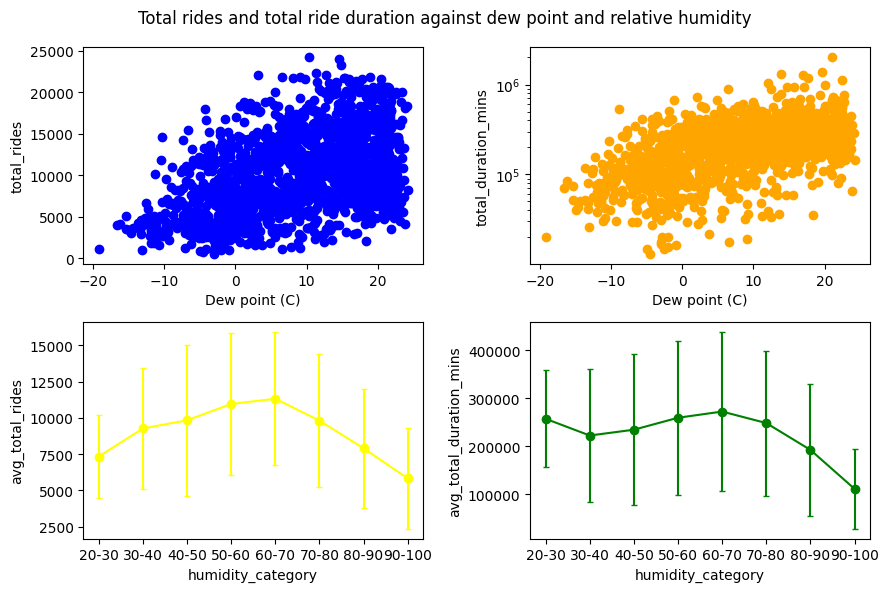

In [48]:
fig, ax = plt.subplots(2, 2, figsize = (9, 6))

x1 = rides_weather['dew']
x2 = rides_humidity['humidity_category']
y1 = rides_weather['total_rides']
y2 = rides_weather['total_duration_mins']
y3 = rides_humidity['avg_total_rides']
y4 = rides_humidity['avg_total_duration_mins']
error1 = rides_humidity['std_total_rides']
error2 = rides_humidity['std_duration_mins']

plt.subplot(2, 2, 1)
plt.scatter(x1, y1, color = 'blue')
plt.xlabel('Dew point (C)')
plt.ylabel('total_rides')

plt.subplot(2, 2, 2)
plt.scatter(x1, y2, color = 'orange')
plt.xlabel('Dew point (C)')
plt.ylabel('total_duration_mins')
plt.yscale(value = 'log', nonpositive = 'clip')

plt.subplot(2, 2, 3)
plt.errorbar(x2, y3, yerr = error1, color = 'yellow', capsize = 2, capthick = 1)
plt.scatter(x2, y3, color = 'yellow')
plt.xlabel('humidity_category')
plt.ylabel('avg_total_rides')

plt.subplot(2, 2, 4)
plt.errorbar(x2, y4, yerr = error2, color = 'green', capsize = 2, capthick = 1)
plt.scatter(x2, y4, color = 'green')
plt.xlabel('humidity_category')
plt.ylabel('avg_total_duration_mins')

fig.suptitle('Total rides and total ride duration against dew point and relative humidity')
plt.tight_layout()
plt.show()

This shows that there is a weak correlation between total rides and dew point and a somewhat moderate correlation between total duration and dew point.

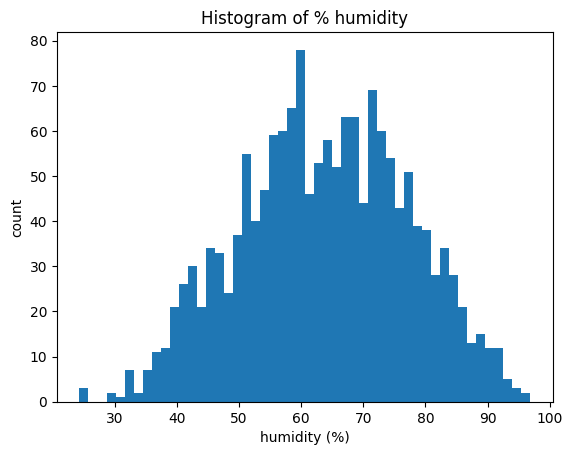

In [49]:
N_bins = 50

x = rides_weather['humidity']

fig, ax = plt.subplots()

plt.hist(x, bins = N_bins)
plt.xlabel('humidity (%)')
plt.ylabel('count')
plt.title('Histogram of % humidity')
plt.show()

This histogram calls into question about the conclusions drawn from previous graph because this shows there are many more observations from the middle than the extremes, meaning that the sums of the total rides would not be equally represented across each category.

### Output the rides_weather dataset for modeling in another notebook

In [52]:
rides_weather.to_csv('rides_weather.csv', index = False)